# Pré Treino Usando arquitetura UNITER

## Setup

In [1]:
!nvidia-smi

Mon Jan 11 12:30:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade pyarrow --quiet
!pip install --upgrade future --quiet
!pip install --upgrade transformers --quiet
!pip install --upgrade datasets --quiet
!pip install --upgrade neptune-client --quiet

!pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade --quiet

     |████████████████████████████████| 17.7MB 342kB/s 
     |████████████████████████████████| 829kB 14.4MB/s 
     |████████████████████████████████| 1.5MB 14.8MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 2.9MB 56.4MB/s 
     |████████████████████████████████| 163kB 14.2MB/s 
     |████████████████████████████████| 245kB 29.1MB/s 
     |████████████████████████████████| 102kB 6.0MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 204kB 16.1MB/s 
     |████████████████████████████████| 163kB 23.3MB/s 
     |████████████████████████████████| 133kB 29.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 27

Download das fontes de pré-treinamento.

In [3]:
!mkdir -p ./fonts
!wget -O ./fonts/Arial.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/arial.ttf?raw=true
!wget -O ./fonts/Lato-Regular.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Lato-Regular.ttf?raw=true
!wget -O ./fonts/Lato-Thin.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Lato-Thin.ttf?raw=true
!wget -O ./fonts/Lato-ThinItalic.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Lato-ThinItalic.ttf?raw=true
!wget -O ./fonts/Raleway-Regular.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Raleway-Regular.ttf?raw=true
!wget -O ./fonts/Roboto-Regular.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Roboto-Regular.ttf?raw=true
!wget -O ./fonts/Roboto-Thin.ttf --quiet https://github.com/lersouza/receipt-ocr/blob/main/fonts/Roboto-Thin.ttf?raw=true

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import torch

from datasets import load_dataset
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
from transformers import T5TokenizerFast, T5Model, T5ForConditionalGeneration

import pytorch_lightning as pl

from argparse import Namespace
from getpass import getpass
from itertools import product
from pathlib import Path
from PIL import Image, ImageFont, ImageDraw
from random import choice, randint, random, sample

from google.colab import drive

from typing import Tuple, List, Callable

%matplotlib inline

## Parâmetros e volumes

In [5]:
TEST_MODEL = False
OVERFIT_ONE_BATCH = False

if os.path.exists('./neptune_key'):
    with open('./neptune_key', 'r') as nep_key:
        all_lines = nep_key.readlines()

        NEPTUNE_API_KEY = all_lines[0].strip()
        NEPTUNE_PROJECT = all_lines[1].strip()
else:
    NEPTUNE_API_KEY = getpass('NEPTUNE KEY:')
    NEPTUNE_PROJECT = input('NEPTUNE PROJECT:')

    with open('./neptune_key', 'w+') as nep_key:
        nep_key.writelines([NEPTUNE_API_KEY + '\n', NEPTUNE_PROJECT + '\n'])


drive.mount('./drive')

NEPTUNE KEY:··········
NEPTUNE PROJECT:leandrors/sroie
Mounted at ./drive


## Dataset

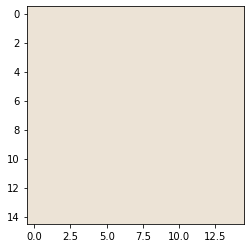

In [6]:
BACK_COLORS = ['#FFFFFF', '#B6BAB6', '#ECE3D6']
FONT_COLORS = ['#000000', '#070138']


def create_image(size: Tuple[int, int] = (300, 600)) -> Image:
    """
    Creates an image of of size `size`, in RGB scheme.
    The image's background color is chosen at random from `BACK_COLORS`.
    """
    backround_color = choice(BACK_COLORS)
    image = Image.new('RGB', size, color=backround_color)

    return image


image = create_image((15, 15))
plt.imshow(image)

In [7]:
def list_available_fonts(fonts_path: str,
                         sizes_range: range = None,
                         return_type: str = 'image_font'):
    """
    Lists a combination of (font, color) for all available fonts in `font_path`
    and sizes in `sizes_range`.

    If `sizes_range` is not specified, we assume a range from 16 to 22.

    It is also possible to control how the data is returned:
    - If return_type is equals to `'image_font'` (default), the resulting list will
      contain objects of type `ImageFont`.

    - Otherwise, it will be a list of strings in the format
      `'font name, font size'` will be returned.
    """
    available_fonts = list(Path(fonts_path).glob('**/*.ttf'))
    available_sizes = range(16, 22) if sizes_range is None else sizes_range

    all_fonts = product(available_fonts, available_sizes)

    def create_font(font_name: str, font_size: int):
        if return_type == 'image_font':
            return ImageFont.truetype(str(font_name), int(font_size))

        return f'{font_name}, {font_size}'

    return [create_font(f, s) for f, s in all_fonts]


list_available_fonts('./fonts', return_type='str')

['fonts/Lato-Thin.ttf, 16',
 'fonts/Lato-Thin.ttf, 17',
 'fonts/Lato-Thin.ttf, 18',
 'fonts/Lato-Thin.ttf, 19',
 'fonts/Lato-Thin.ttf, 20',
 'fonts/Lato-Thin.ttf, 21',
 'fonts/Lato-Regular.ttf, 16',
 'fonts/Lato-Regular.ttf, 17',
 'fonts/Lato-Regular.ttf, 18',
 'fonts/Lato-Regular.ttf, 19',
 'fonts/Lato-Regular.ttf, 20',
 'fonts/Lato-Regular.ttf, 21',
 'fonts/Roboto-Regular.ttf, 16',
 'fonts/Roboto-Regular.ttf, 17',
 'fonts/Roboto-Regular.ttf, 18',
 'fonts/Roboto-Regular.ttf, 19',
 'fonts/Roboto-Regular.ttf, 20',
 'fonts/Roboto-Regular.ttf, 21',
 'fonts/Roboto-Thin.ttf, 16',
 'fonts/Roboto-Thin.ttf, 17',
 'fonts/Roboto-Thin.ttf, 18',
 'fonts/Roboto-Thin.ttf, 19',
 'fonts/Roboto-Thin.ttf, 20',
 'fonts/Roboto-Thin.ttf, 21',
 'fonts/Lato-ThinItalic.ttf, 16',
 'fonts/Lato-ThinItalic.ttf, 17',
 'fonts/Lato-ThinItalic.ttf, 18',
 'fonts/Lato-ThinItalic.ttf, 19',
 'fonts/Lato-ThinItalic.ttf, 20',
 'fonts/Lato-ThinItalic.ttf, 21',
 'fonts/Arial.ttf, 16',
 'fonts/Arial.ttf, 17',
 'fonts/Arial.tt

In [8]:
FONTS = list_available_fonts('./fonts')

In [9]:
def fit_text(tokens: List[str],
             draw: ImageDraw.Draw,
             font: ImageFont,
             max_width: int,
             max_height: int,
             offset_x: int = 0,
             offset_y: int = 0,
             line_spacing: int = 0,
             max_height_threshold: int = 20):
    """
    Fits the given `tokens` array into many lines based on
    `draw`, `font` and desired `max_width` and `max_height`.

    This function returns a tuple:
    - `[0]`: Is a list of lines in the images. For each line, a list of tokens \
             is provided (as a result of `line.split()`).
    - `[1]`: A list of width for each line.
    - `[2]`: The initial position where the tokens do not fit anymore.

    A `offset_x` and `offset_y` can be provided.
    Also, an additional space between lines can be provided in `line_spacing`.

    PS: The calculations are based on estimations returned by `draw.textsize()`.
    """
    lines = [[]]
    sizes = [[offset_x, 0]]
    unfit = None

    total_height = offset_y

    for i, token in enumerate(tokens):
        # we include spaces for size calculation, since we are
        # running through tokens
        text_to_draw = token + ' '
        w, h = draw.textsize(text_to_draw, font=font)

        estimated_height = (total_height + h + line_spacing + \
                            max_height_threshold)

        if sizes[-1][0] + w > max_width:
            lines.append([])
            sizes.append([offset_x, h])

            total_height = sum([i[1] for i in sizes]) + offset_y

        if estimated_height >= max_height:  # put some bottom margin
            unfit = i
            break

        lines[-1].append(token)
        sizes[-1][0] += w
        sizes[-1][1] = max(h, sizes[-1][1])

    return lines, sizes, unfit

In [10]:
image = create_image((256, 256))
draw = ImageDraw.Draw(image)
text = 'this is a very very very very long text for fitting into the image'
font = choice(FONTS)

lines, sizes, unfit = fit_text(text.split(), draw, font, 256, 256)

print('Lines:', lines)
print('Sizes:', sizes)
print('Unfit:', unfit)

Lines: [['this', 'is', 'a', 'very', 'very', 'very', 'very', 'long'], ['text', 'for', 'fitting', 'into', 'the', 'image']]
Sizes: [[234, 19], [208, 19]]
Unfit: None


['this', 'is', 'a', 'very', 'very', 'very', 'long', 'text', 'for', 'test']


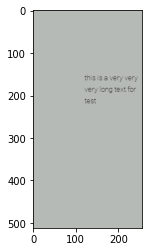

In [11]:
def generate_image_from_text(text: str, size: Tuple[int, int]):
    """
    Generate an image from a piece of text in `image_data`.
    - `text`: the text to be used in the target image.
    - `size`: A tuple indicating the size of target image.

    Images are generated in `size`, RGB format.
    Arbitrary font and colors will be choosen for the image.
    """
    size = size or (300, 600)
    image = create_image(size)
    draw = ImageDraw.Draw(image)
    font = choice(FONTS)
    forecolor = choice(FONT_COLORS)
    line_spacing = randint(0, 10)

    offset_x = randint(0, size[0] // 2)
    offset_y = randint(0, size[1] // 2)

    original = text.split()

    lines, sizes, unfit = fit_text(original,
                                   draw,
                                   font,
                                   size[0],
                                   size[1],
                                   offset_x=offset_x,
                                   offset_y=offset_y,
                                   line_spacing=line_spacing)

    if unfit:
        original = original[:unfit]

    y = offset_y

    for line, text_size in zip(lines, sizes):
        x = offset_x

        # We generate the image itself, line by line
        draw.text((offset_x, y), ' '.join(line), font=font, fill=forecolor)
        y += text_size[1] + line_spacing

    return image, original

image, text = generate_image_from_text(
    'this is a very very very long text for test', (256, 512))

print(text)
plt.imshow(image)

### Extraindo Patches das Imagens

Vou Usar patches (subplots da imagem) para alimentar um Image Embedder, parecido com a abordagem do UNITER.

torch.Size([1, 10, 64, 64])


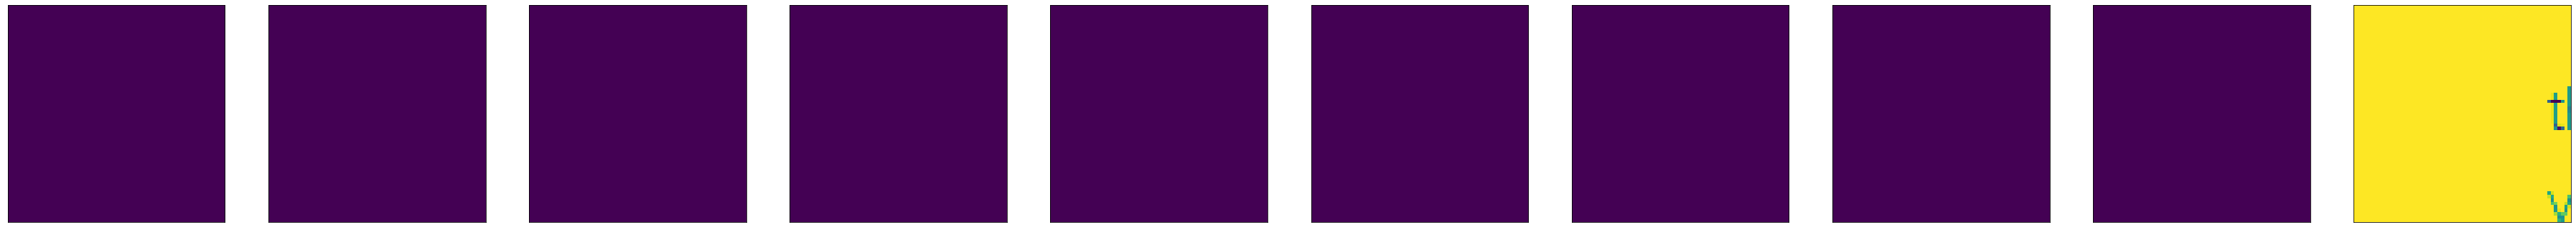

In [12]:
PATCH_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

def extract_patches(image,
                    patch_height: int = 16,
                    patch_width:int = 16,
                    max_patches: int = 256,
                    padding: bool = True,
                    padding_value: int = -100):
    """
    Inspired by: https://discuss.pytorch.org/t/slicing-image-into-square-patches/8772/3
    """
    flat_image = PATCH_TRANSFORMS(image)
    patches = flat_image.data.unfold(1, patch_height, patch_height) \
                             .unfold(2, patch_width, patch_width)

    # At the end, remove the channel (since it is always one)
    patches = torch.flatten(patches, start_dim=1, end_dim=2).squeeze(0)

    # Check if padding is necessary
    if patches.shape[0] < max_patches and padding is True:
        padding = torch.zeros(max_patches - patches.shape[0],
                              patch_height,
                              patch_width)
        
        patches = torch.cat((patches, padding), dim=0)

    # Limit number of patches
    return patches[:max_patches, : , :]


def visualize_patches(patches):
    """Imshow for Tensor.""" 


    print(patches.shape)
    patch_height = patches.shape[-2]
    patch_width = patches.shape[-1]
    num_patches = patches.shape[-3]

    transp = transforms.ToPILImage()

    fig = plt.figure(figsize=(64, 32))

    for i in range(num_patches):
        inp = transp(patches[0][i])
        inp = np.array(inp)
        ax = fig.add_subplot(1, num_patches, i + 1, xticks=[], yticks=[])
        plt.imshow(inp)


# Testing with dummy image
visualize_patches(extract_patches(image, 64, 64, padding=False, max_patches=10).unsqueeze(0))

### Removendo \<pad> e \</s>

In [13]:
def decode_sentence_batch(tokenizer, input_ids):

    def remove_pad(text):
        return text.replace(tokenizer.pad_token, '')

    def remove_eos(text):
        return text.replace(tokenizer.eos_token, '')

    dec = tokenizer.decode
    return [remove_pad(remove_eos(dec(s))).strip() for s in input_ids]


tok = T5TokenizerFast.from_pretrained('t5-base')
input_ids = tok('this is a string for testing',
                max_length=20,
                padding='max_length',
                return_tensors='pt').input_ids

print(input_ids.shape)
print(tok.batch_decode(input_ids))
print(decode_sentence_batch(tok, input_ids))


torch.Size([1, 20])
['this is a string for testing</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
['this is a string for testing']


### Classe do Dataset

In [14]:
def mask_text(tokenizer: T5TokenizerFast,
              text_to_mask: List[str],
              mask_prob: float = 0.15):

    iter = (t for t in tokenizer.additional_special_tokens)
    rand_replace = lambda word: word if random() > mask_prob else next(iter)

    masked = [rand_replace(w) for w in text_to_mask]
    labels = [f'{m} {text_to_mask[i]}' for i, m in enumerate(masked) if m in tokenizer.additional_special_tokens]

    return masked, labels

In [15]:
mask_text(tok, text)

(['<extra_id_0>',
  '<extra_id_1>',
  'a',
  'very',
  'very',
  'very',
  'long',
  'text',
  'for',
  'test'],
 ['<extra_id_0> this', '<extra_id_1> is'])

In [16]:
class WikiTextPreTrainDataset(Dataset):
    """
    Dataset for Wiki Content. This dataset uses `wikitext-103-v1` from
    `datasets` pip package. Is transforms text segments into images for 
    pretraining.
    """
    IMAGE_TO_TENSOR = transforms.ToTensor()

    def __init__(self,
                 image_size: Tuple[int, int],
                 tokenizer: str,
                 dataset_size: int = 32_000,
                 sample_min_len: int = 128,
                 target_max_len: int = 128,
                 labels_max_len: int = 64,
                 enhance_factor: int = 1,
                 patches_size: int = (16, 16),
                 max_patches: int = 256,
                 return_image: bool = False):
        """
        - patches_size: tamanho dos patches para extrair da imagem.
                        Tupla com (Height, Width) para cada patch.
        """
        
        wiki = load_dataset('wikitext', 'wikitext-103-v1', split='train')
        wiki = wiki.filter(lambda example: len(example['text']) >= sample_min_len)
        
        self.wiki_data = wiki[:dataset_size]['text']
        self.wiki_data_size = len(self.wiki_data)
        self.enhance_factor = enhance_factor

        self.image_size = image_size
        self.target_max_length = target_max_len
        self.labels_max_len = labels_max_len
        self.tokenizer = T5TokenizerFast.from_pretrained(tokenizer)

        self.patches_size = patches_size
        self.max_patches = max_patches
        self.return_image = return_image

    def __len__(self):
        return self.wiki_data_size * self.enhance_factor

    def __getitem__(self, idx):
        actual_item = self.wiki_data[idx % self.wiki_data_size]
        image, text = generate_image_from_text(actual_item, self.image_size)

        # Extract image patches
        patches = extract_patches(
            image, self.patches_size[0], self.patches_size[1], self.max_patches)
        
        masked, labels = mask_text(self.tokenizer, text)

        tokenized = self.tokenizer(' '.join(text),
                                   max_length=self.target_max_length,
                                   padding='max_length',
                                   truncation=True)
        
        masked_input_ids = self.tokenizer(' '.join(masked),
                                          max_length=self.target_max_length,
                                          padding='max_length',
                                          truncation=True)

        target = self.tokenizer(' '.join(labels),
                                max_length=self.labels_max_len,
                                padding='max_length',
                                truncation=True)
        output = {
            'patches': patches,
            'input_ids': torch.tensor(tokenized.input_ids, dtype=torch.long),
            'masked_input_ids': torch.tensor(masked_input_ids.input_ids, dtype=torch.long),
            'masked_labels': torch.tensor(target.input_ids, dtype=torch.long),
            'masked_original': ' '.join(labels)
        }

        if self.return_image:
            output['image'] = image
        
        return output

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91. Subsequent calls will reuse this data.


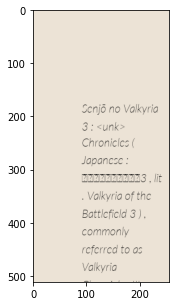

In [17]:
dataset = WikiTextPreTrainDataset((256, 512), 't5-small', patches_size=(64, 64),
                                  return_image=True)
demo_sample = dataset[0]

plt.figure(figsize=(5, 5))
plt.imshow(demo_sample['image'])

In [18]:
visualize_patches(demo_sample['patches'].unsqueeze(0))

torch.Size([1, 256, 64, 64])


torch.Size([1, 256, 64, 64])


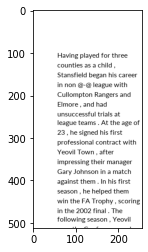

In [19]:
demo_sample = dataset[1002]

plt.imshow(demo_sample['image'])
visualize_patches(demo_sample['patches'].unsqueeze(0))

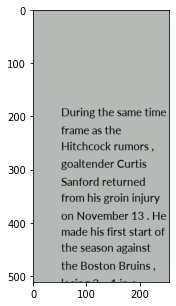

In [20]:
demo_sample = dataset[100]

plt.figure(figsize=(5, 5))
plt.imshow(demo_sample['image'])

In [21]:
demo_sample['input_ids']

tensor([    3,  2092,     8,   337,    97,  2835,    38,     8,   454,  7059,
        12105,     3, 24637,     3,     6,  1288,    17,  3868,  4116,    17,
          159,  1051,  2590,  3666,    45,   112,     3,  3844,    77,  2871,
           30,  1671,  1179,     3,     5,   216,   263,   112,   166,   456,
           13,     8,   774,   581,     8,  5053,   272, 23162,     3,     6,
         5489,   204,     3,   104,   209,    16,     3,     9,  4279,   670,
            3,     5,  1051,  2590,  2925,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [22]:
dataset.tokenizer.batch_decode(demo_sample['input_ids'].unsqueeze(0))

['During the same time frame as the Hitchcock rumors, goaltender Curtis Sanford returned from his groin injury on November 13. He made his first start of the season against the Boston Bruins, losing 2 – 1 in a shootout. Sanford continued</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [23]:
print(dataset.tokenizer.batch_decode(demo_sample['masked_input_ids'].unsqueeze(0)))
print(dataset.tokenizer.batch_decode(demo_sample['masked_labels'].unsqueeze(0)))

['During the<extra_id_0> time frame as the<extra_id_1> rumors, goaltender Curtis<extra_id_2><extra_id_3> from<extra_id_4> groin injury<extra_id_5><extra_id_6> 13. He<extra_id_7> his first start of the season against<extra_id_8> Boston Bruins, losing 2 – 1<extra_id_9><extra_id_10> shootout. Sanford continued</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
['<extra_id_0> same<extra_id_1> Hitchcock<extra_id_2> Sanford<extra_id_3> returned<extra_id_4> his<extra_id_5> on<extra_id_6> November<extra_id_7> made<extra_id_8> the<extra_id_9> in<extra_id_10> a</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [24]:
demo_sample['masked_input_ids']

tensor([    3,  2092,     8, 32099,    97,  2835,    38,     8, 32098,     3,
        24637,     3,     6,  1288,    17,  3868,  4116,    17,   159, 32097,
        32096,    45, 32095,     3,  3844,    77,  2871, 32094, 32093,  1179,
            3,     5,   216, 32092,   112,   166,   456,    13,     8,   774,
          581, 32091,  5053,   272, 23162,     3,     6,  5489,   204,     3,
          104,   209, 32090, 32089,  4279,   670,     3,     5,  1051,  2590,
         2925,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [25]:
print(dataset.tokenizer.additional_special_tokens_ids[:3])
print(dataset.tokenizer.additional_special_tokens[:3])

[32099, 32098, 32097]
['<extra_id_0>', '<extra_id_1>', '<extra_id_2>']


## Funções de Geração de texto

In [26]:
def greedy_generate(model,
                    tokenizer,
                    embeddings,
                    device,
                    max_sentence_length: int = 128):
    """
    Realiza a geração de texto usando a técnica Greedy.
    Este método foi construído para superar algumas limitações de uso do 
    método generate dos transformers por conta do uso de um encoder
    de imagem.
    """
    eos_token_id = tokenizer.eos_token_id
    pad_token_id = tokenizer.pad_token_id
    start_token_id = model.decoder.config.decoder_start_token_id

    decoded_ids = torch.full(
        (embeddings.shape[0], 1), # Shape = (Batch Size, 1)
        start_token_id,
        dtype=torch.long, device=device)

    t5_encoder_outputs = model.get_encoder()(
        inputs_embeds=embeddings)

    for step in range(1, max_sentence_length):
        output = model(
            decoder_input_ids=decoded_ids,
            encoder_outputs=t5_encoder_outputs)

        logits = output.logits

        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        if torch.eq(next_token_id, eos_token_id).all():
            break  # Early stop, when all sentences reached the end
    
    return decoded_ids

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [27]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))


def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def extract_masked_tokens(text):
    matches = re.findall(r'<(extra_id_\d+)>\s*([^\<]+)\s*', text)
    return set([f'{k}={v.strip()}' for k, v in matches])


def accuracy(predicted, expected):
    predicted_set = extract_masked_tokens(predicted)
    expected_set = extract_masked_tokens(expected)    

    if not predicted_set and not expected_set:
        return 1.0  # Tanto previsão quanto expectativa são conjuntos vazios
                    # Então assumo que o modelo acertou

    total = max(len(predicted_set), len(expected_set))

    return len(predicted_set & expected_set) / total

In [28]:
compute_f1(a_gold='He likes pizza', a_pred='she likes pizza')

0.6666666666666666

In [29]:
compute_exact(a_gold='He likes pizza', a_pred='she likes pizza')

0

In [30]:
predicted = (
    '<extra_id_0> is <extra_id_1> transitional <extra_id_2> zones '
    '<extra_id_3> a <extra_id_4> in my city <extra_id_5> in my city')

expected = (
    '<extra_id_0> a <extra_id_1> transitional <extra_id_2> zones '
    '<extra_id_3> a <extra_id_4> in my city')

accuracy(predicted, expected)

0.6666666666666666

## Modelo

In [31]:
class ImageEmbedding(nn.Module):
    """ Inspired by UNITER UniterImageEmbeddings. """

    def __init__(self,
                 hidden_size: int,
                 patches_size: Tuple[int, int] = (16, 16),
                 hidden_dropout_prob: float = 0.1):
        super().__init__()

        img_dim = patches_size[0] * patches_size[1]

        self.img_linear = nn.Linear(img_dim, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, patches):
        batch_size = patches.shape[0]
        seq_length = patches.shape[1]

        img_feat = patches.reshape(batch_size, seq_length, -1)

        image_embeddings = self.LayerNorm(self.img_linear(img_feat))
        image_embeddings = self.dropout(image_embeddings)
        
        return image_embeddings

In [32]:
img_emb = ImageEmbedding(768)
image, _ = generate_image_from_text('this is just a test for image patching', (256, 256))
patches = extract_patches(image, 16, 16).unsqueeze(0)

embeddings = img_emb(patches)
print(embeddings.shape)

del img_emb
del embeddings

torch.Size([1, 256, 768])


In [33]:
class JointEmbedder(nn.Module):
    def __init__(self,
                 base_model: T5Model,
                 patches_size: Tuple[int, int] = (16, 16)):
        super().__init__()

        hidden_size = base_model.config.d_model

        self.image_embedder = ImageEmbedding(
            hidden_size,
            patches_size,
            getattr(base_model.config, 'dropout_rate', 0.1))
        
        self.text_embedder = base_model.get_input_embeddings()

        self.token_types_embedding = nn.Embedding(2, hidden_size)

    def forward(self, patches, masked_input_ids):
        batch_size, img_seq_length = patches.shape[:2]

        image_embeddings = self.image_embedder(patches)
        text_embeddings = self.text_embedder(masked_input_ids)

        image_token_types = torch.zeros(
            batch_size,
            img_seq_length,
            dtype=torch.long,
            device=patches.device)

        text_token_types = torch.ones(
            batch_size,
            masked_input_ids.shape[1],
            dtype=torch.long,
            device=patches.device)

        token_types = torch.cat((image_token_types, text_token_types), dim=1)
        token_type_embeddings = self.token_types_embedding(token_types)

        input_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        input_embeddings = input_embeddings + token_type_embeddings

        return input_embeddings

In [34]:
t5_demo = T5Model.from_pretrained('t5-base')
joint_embedder = JointEmbedder(t5_demo)

tokens = demo_sample['masked_input_ids'].unsqueeze(0)  # Batch Size
embeddings = joint_embedder(patches, tokens)

print('Patches', patches.shape)  # a primeira dimensão seria o Canal, mas trabalho apenas com 1 (GrayScale), portanto posso usar como batch
print('Tokens', tokens.shape)

print(embeddings.shape)

del joint_embedder
del embeddings
del t5_demo

Some weights of the model checkpoint at t5-base were not used when initializing T5Model: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Patches torch.Size([1, 256, 16, 16])
Tokens torch.Size([1, 128])
torch.Size([1, 384, 768])


In [35]:
class PreTrainModel(pl.LightningModule):
    def __init__(self,
                 model_name: str,
                 patches_size: Tuple[int, int],
                 learning_rate: float,
                 generator_function_name: str = 'greedy_generate',
                 max_sentence_length: int = 128,
                 **kwargs):

        super().__init__()

        self.save_hyperparameters()

        t5_model = T5ForConditionalGeneration.from_pretrained(model_name)
        
        self.transformer = t5_model
        self.embedder = JointEmbedder(self.transformer, patches_size)
        
        self.generate = globals()[generator_function_name]
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        
    def forward(self, patches, masked_input_ids, masked_labels, **kwargs):
        embeddings = self.embedder(patches, masked_input_ids)

        if self.training:
            labels = masked_labels.masked_fill(
                masked_labels == self.tokenizer.pad_token_id,
                -100)

            output = self.transformer(inputs_embeds=embeddings,
                                      labels=labels,
                                      return_dict=True)
            
            return output.loss
        else:
            return self.generate(self.transformer,
                                 self.tokenizer,
                                 embeddings,
                                 self.device,
                                 self.hparams.max_sentence_length)
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        loss = self(**batch)

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        return self._evaluation_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self._evaluation_epoch_end(outputs, 'val')

    def test_step(self, batch, batch_idx):
        return self._evaluation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        return self._evaluation_epoch_end(outputs, 'test')

    def _evaluation_step(self, batch, batch_idx):
        predicted = self(**batch)
        expected = batch['masked_original']

        predicted_texts = decode_sentence_batch(self.tokenizer, predicted)
        
        return {'predicted': predicted_texts, 'actual': expected}

    def _evaluation_epoch_end(self, outputs, prefix='val'):
        predicted = [o for bouts in outputs for o in bouts['predicted']]
        actual = [o for bouts in outputs for o in bouts['actual']]

        f1_by_sample = [compute_f1(a, p) for a, p in zip(predicted, actual)]
        em_by_sample = [compute_exact(a, p) for a, p in zip(predicted, actual)]
        ac_by_sample = [accuracy(a, p) for a, p in zip(predicted, actual)]

        sample_idx = sample(range(len(predicted)), 5)
        
        if self.current_epoch % 2 == 0:
            for i in sample_idx:
                self.logger.experiment.log_text(
                    'predictions',
                    f'Actual: {actual[i]}. Predicted: {predicted[i]}.')

        f1 = 100 * (sum(f1_by_sample) / len(f1_by_sample))
        em = 100 * (sum(em_by_sample) / len(em_by_sample))
        ac = 100 * (sum(ac_by_sample) / len(ac_by_sample))

        self.log(f'{prefix}_f1', torch.tensor(f1))
        self.log(f'{prefix}_em', torch.tensor(em))
        self.log(f'{prefix}_accuracy', torch.tensor(ac))

## Teste do Modelo

In [36]:
if TEST_MODEL or OVERFIT_ONE_BATCH:
    train_dataset = WikiTextPreTrainDataset((256, 256), 't5-base')
    model_for_testing = PreTrainModel('t5-base', (16, 16), 1e-4)
    trainer = pl.Trainer(gpus=1, fast_dev_run=True)

    loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

    try:
        trainer.fit(model_for_testing, loader)
    finally:
        del model_for_testing

## Overfit em 1 Batch

In [37]:
if OVERFIT_ONE_BATCH:
    model_for_testing = PreTrainModel('t5-base', (16, 16), 1e-4)
    trainer = pl.Trainer(gpus=1, overfit_batches=1, max_epochs=10)

    try:
        trainer.fit(model_for_testing, loader)
    finally:
        del model_for_testing

## Treino

### Parâmetros de treino

In [38]:
train_params = {
    'seed': 42,
    'image_width': 256,
    'image_height': 512,
    'patches_size': (16, 16),
    'max_patches': 256,
    'target_max_length': 128,
    'max_sentence_length': 128,
    'model_name': 't5-base',
    'learning_rate': 1e-4,
    'max_epochs': 10,
    'precision': 32,
    'gpus': 1,
    'dataset_size': 128000,
    'train_split': 102400,
    'val_split': 25600,
    'batch_size': 8
}

In [39]:
pl.seed_everything(train_params['seed'])

42

### Checkpoints

In [40]:
CHECKPOINTS_PATH = './drive/My Drive/IA376J/checkpoints/uniter-for-sroie-final'
CHECKPOINTS_FILE_PREFIX = 'pretreino-uniter-'
CHECKPOINTS_FILE_NAME = CHECKPOINTS_FILE_PREFIX + '{epoch:02d}-{val_em:.2f}-{val_f1:.2f}'


# Make sure checkoint path is there
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)


def sort_by_epoch(path):
    return re.findall(r'epoch=([0-9]+)', str(path))[0]


if os.path.exists(os.path.join(CHECKPOINTS_PATH, 'last.ckpt')):
    resume_from_checkpoint = os.path.join(CHECKPOINTS_PATH, 'last.ckpt')
else:    
    available_checkpoints = Path(CHECKPOINTS_PATH).glob(f'{CHECKPOINTS_FILE_PREFIX}*.ckpt')
    available_checkpoints = sorted(available_checkpoints, key=sort_by_epoch, reverse=True)
    resume_from_checkpoint = next((str(x) for x in available_checkpoints), None)

print('Resuming from Checkpoint:', resume_from_checkpoint)

Resuming from Checkpoint: ./drive/My Drive/IA376J/checkpoints/uniter-for-sroie-final/last.ckpt


In [41]:
model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINTS_PATH,
    filename=CHECKPOINTS_FILE_NAME,
    save_last=True,
    monitor='val_accuracy',
    mode='max')

### Logger

In [42]:
neptune_logger = pl.loggers.NeptuneLogger(
    api_key=NEPTUNE_API_KEY,
    project_name=NEPTUNE_PROJECT,
    experiment_name='sroie-pretrain-uniterbased',
    params=train_params,
    experiment_id='SROIE-2')

NeptuneLogger will work in online mode


### Dados de treino e validação

In [43]:
dataset = WikiTextPreTrainDataset(
    (train_params['image_width'], train_params['image_height']),
    train_params['model_name'],
    patches_size=train_params['patches_size'],
    dataset_size=train_params['dataset_size'],
    max_patches=train_params['max_patches'])

train_ds, val_ds = random_split(dataset,
                                (train_params['train_split'],
                                 train_params['val_split']))

train_loader = DataLoader(train_ds,
                          batch_size=train_params['batch_size'],
                          shuffle=True,
                          num_workers=4)

val_loader = DataLoader(val_ds,
                        batch_size=train_params['batch_size'],
                        shuffle=False,
                        num_workers=4)

Reusing dataset wikitext (/root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91)
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-10a9b3a5bb4d7bf1.arrow


### Treinando


In [44]:
trainer = pl.Trainer.from_argparse_args(
    Namespace(**train_params),
    logger=neptune_logger,
    progress_bar_refresh_rate=20,
    resume_from_checkpoint=resume_from_checkpoint,
    checkpoint_callback=model_checkpoint)

model = PreTrainModel(**train_params)

try:
    trainer.fit(model, train_loader, val_loader)
finally:
    neptune_logger.experiment.stop()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | transformer | T5ForConditionalGeneration | 222 M 
1 | embedder    | JointEmbedder              | 

Saving latest checkpoint...
